In [1]:
from goes2go import GOES
import pandas as pd
from datetime import datetime
import xarray as xr
import subprocess
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
def calculate_degrees(file_id):
    
    # Read in GOES ABI fixed grid projection variables and constants
    x_coordinate_1d = file_id.variables['x'][:]  # E/W scanning angle in radians
    y_coordinate_1d = file_id.variables['y'][:]  # N/S elevation angle in radians
    projection_info = file_id.variables['goes_imager_projection']
    lon_origin = projection_info.longitude_of_projection_origin
    H = projection_info.perspective_point_height+projection_info.semi_major_axis
    r_eq = projection_info.semi_major_axis
    r_pol = projection_info.semi_minor_axis
    
    # Create 2D coordinate matrices from 1D coordinate vectors
    x_coordinate_2d, y_coordinate_2d = np.meshgrid(x_coordinate_1d, y_coordinate_1d)
    
    # Equations to calculate latitude and longitude
    lambda_0 = (lon_origin*np.pi)/180.0  
    a_var = np.power(np.sin(x_coordinate_2d),2.0) + (np.power(np.cos(x_coordinate_2d),2.0)*(np.power(np.cos(y_coordinate_2d),2.0)+(((r_eq*r_eq)/(r_pol*r_pol))*np.power(np.sin(y_coordinate_2d),2.0))))
    b_var = -2.0*H*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    c_var = (H**2.0)-(r_eq**2.0)
    r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)
    s_x = r_s*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    s_y = - r_s*np.sin(x_coordinate_2d)
    s_z = r_s*np.cos(x_coordinate_2d)*np.sin(y_coordinate_2d)
    
    # Ignore numpy errors for sqrt of negative number; occurs for GOES-16 ABI CONUS sector data
    np.seterr(all='ignore')
    
    abi_lat = (180.0/np.pi)*(np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))
    abi_lon = (lambda_0 - np.arctan(s_y/(H-s_x)))*(180.0/np.pi)
    
    return abi_lat, abi_lon

In [7]:
import numpy as np
import xarray as xr
from netCDF4 import Dataset

def DownwardSWProcessingFunction(file):
    print(file)
    ds = xr.open_dataset(file)
    file_id = Dataset(file)

    # Extract latitude and longitude
    abi_lat = ds['lat'].values
    abi_lon = ds['lon'].values

    # Load Reflected Shortwave Radiation (RSR) data
    dsr = ds['DSR'].data


    return abi_lat, abi_lon, dsr


In [8]:
# Directory containing the datasets
base_dir = '/glade/derecho/scratch/adhall/GOESdata/raw_data/GOES_DownwardShortwave/2020/'

# Generate file paths for days 92 through 121
file_paths = [
    f"{base_dir}GOES16_DownwardShortwave_2020day{str(day).zfill(3)}_time1500.nc"
    for day in range(92, 122)
]



/glade/derecho/scratch/adhall/GOESdata/raw_data/GOES_DownwardShortwave/2020/GOES16_DownwardShortwave_2020day092_time1500.nc


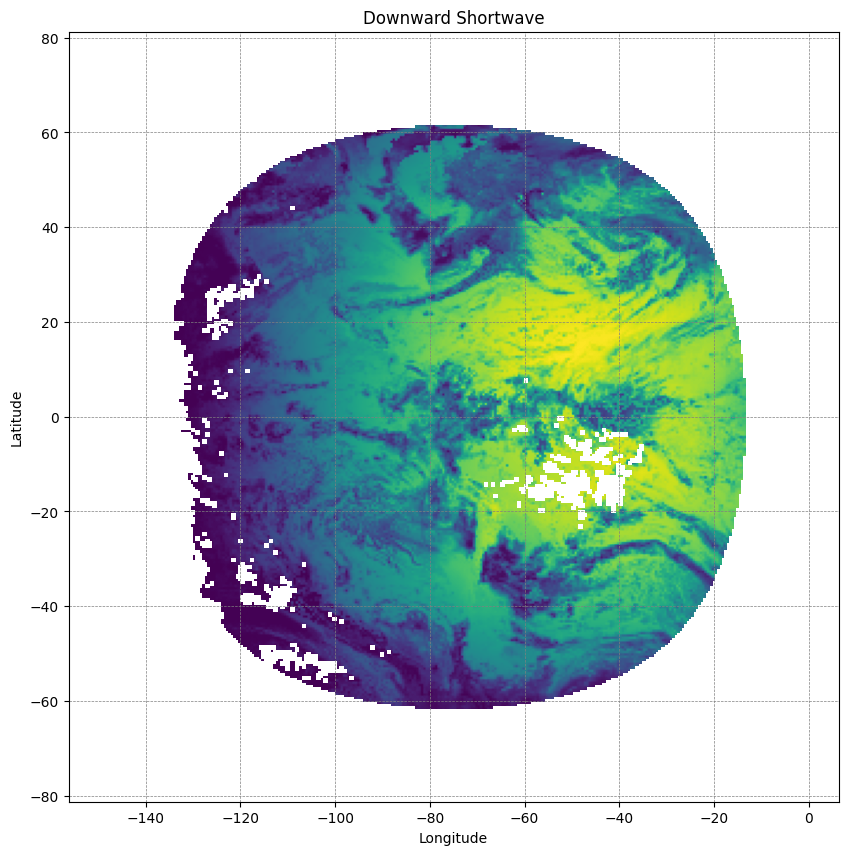

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Test on a single file
file = file_paths[0]  # Replace with the path to your file
abi_lat, abi_lon, dsr = DownwardSWProcessingFunction(file)

# Convert longitudes to [-180, 180] if needed
if np.max(abi_lon) > 180:
    abi_lon = (abi_lon + 180) % 360 - 180

# Plot the RGB image
plt.figure(figsize=(10, 10))
plt.imshow(dsr, origin='upper', extent=[abi_lon.min(), abi_lon.max(), abi_lat.min(), abi_lat.max()])
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Downward Shortwave")

# Add gridlines for reference
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()

In [10]:
file_paths_arr = np.array(file_paths)

In [11]:
file_paths_arr.shape

(30,)

In [13]:
# Initialize empty lists to store results
lat_list = []
lon_list = []
dsr_list = []

# Loop through each file in the array
for file in file_paths_arr:
    lat, lon, dsr = DownwardSWProcessingFunction(file)
    lat_list.append(lat)
    lon_list.append(lon)
    dsr_list.append(dsr)

# Combine results into arrays or keep them as lists for further processing
dsr_lat = lat_list
dsr_lon = lon_list
dsr_dsr = dsr_list


/glade/derecho/scratch/adhall/GOESdata/raw_data/GOES_DownwardShortwave/2020/GOES16_DownwardShortwave_2020day092_time1500.nc
/glade/derecho/scratch/adhall/GOESdata/raw_data/GOES_DownwardShortwave/2020/GOES16_DownwardShortwave_2020day093_time1500.nc
/glade/derecho/scratch/adhall/GOESdata/raw_data/GOES_DownwardShortwave/2020/GOES16_DownwardShortwave_2020day094_time1500.nc
/glade/derecho/scratch/adhall/GOESdata/raw_data/GOES_DownwardShortwave/2020/GOES16_DownwardShortwave_2020day095_time1500.nc
/glade/derecho/scratch/adhall/GOESdata/raw_data/GOES_DownwardShortwave/2020/GOES16_DownwardShortwave_2020day096_time1500.nc
/glade/derecho/scratch/adhall/GOESdata/raw_data/GOES_DownwardShortwave/2020/GOES16_DownwardShortwave_2020day097_time1500.nc
/glade/derecho/scratch/adhall/GOESdata/raw_data/GOES_DownwardShortwave/2020/GOES16_DownwardShortwave_2020day098_time1500.nc
/glade/derecho/scratch/adhall/GOESdata/raw_data/GOES_DownwardShortwave/2020/GOES16_DownwardShortwave_2020day099_time1500.nc
/glade/d

In [17]:
# Initialize the dictionary
data_dict_dsr = {}

# Assuming file_paths_arr corresponds to Julian days 92 to 121
for i, day in enumerate(range(92, 122)):  # Map index `i` to Julian day
    # Populate the dictionary with data from the lists
    data_dict_dsr[f'Julian_day_{day}'] = {
        'downward_shortwave': {
            'lat': lat_list[i],
            'lon': lon_list[i],
            'dsr': dsr_list[i]
        }
    }

# `data_dict` now contains the desired structure


In [18]:
import pickle
# Save the dictionary to a file using pickle
file_path = '/glade/work/adhall/Data/GOES_DATA/ProcessGOESData/ProcessedDictionaries/data_dict_dsr.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(data_dict_dsr, f)

# Confirm file saved
print(f"Data dictionary saved to {file_path}")

Data dictionary saved to /glade/work/adhall/Data/GOES_DATA/ProcessGOESData/ProcessedDictionaries/data_dict_dsr.pkl


In [16]:
from goes2go import GOES
import pandas as pd
from datetime import datetime
import xarray as xr
import subprocess
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [19]:
# Define the path where the dictionary is saved
file_path = '/glade/work/adhall/Data/GOES_DATA/ProcessGOESData/ProcessedDictionaries/data_dict_dsr.pkl'

# Load the dictionary from the file
with open(file_path, 'rb') as f:
    data_dict_dsr = pickle.load(f)



In [22]:
# Extract cloud optical depth (lat, lon, cod) for all Julian days into separate arrays
dsr_lat = np.array([data_dict_dsr[day]['downward_shortwave']['lat'] for day in data_dict_dsr])
dsr_lon = np.array([data_dict_dsr[day]['downward_shortwave']['lon'] for day in data_dict_dsr])
dsr_dsr = np.array([data_dict_dsr[day]['downward_shortwave']['dsr'] for day in data_dict_dsr])

# Verify by printing the shape of the arrays
print("DSR Shape:", dsr_dsr.shape)

DSR Shape: (30, 326, 326)


In [24]:
dataset_metadata = {
    "title": "Downward SW Radiation (RSR)",
    "description": "Combined DSR data over time for Julian days 91 to 100.",
    "source": "GOES-16 Satellite Cloud and Moisture Imagery",
    "history": "Created on 2024-10-24 by combining RSR over time.",
    "institution": "University of Washington",
    "references": "https://registry.opendata.aws/noaa-goes/",
    "time_units": "Julian days",
    "lat_units": "degrees_north",
    "lon_units": "degrees_east",
    "dsr_units": "W/m2"
}
# Assuming time is represented by the Julian days 91 to 100
time = np.array([92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121])

# Extract the RGB data and lat/lon for all days
downward_sw_dsr = np.array([data_dict_dsr[day]['downward_shortwave']['dsr'] for day in data_dict_dsr])

# Extract lat/lon for each day (assuming lat/lon are 2D for each day)
downward_sw_lat = np.array([data_dict_dsr[day]['downward_shortwave']['lat'][:] for day in data_dict_dsr])
downward_sw_lon = np.array([data_dict_dsr[day]['downward_shortwave']['lon'][:] for day in data_dict_dsr])

# Stack the RGB data into a 4D array (time, lat, lon, rgb)
dsr_data = np.stack(downward_sw_dsr, axis=0)

# Create the xarray Dataset with renamed coordinates
DownwardShortwaveDataset = xr.Dataset(
    {
        'DownwardSW': (['time', 'latitude', 'longitude'], dsr_data)
    },
    coords={
        "time": ("time", time, {"units": dataset_metadata["time_units"]}),  # Add units directly to time
        "lat": (['time', 'latitude'], downward_sw_lat, {"units": dataset_metadata["lat_units"]}),  # 1D latitude
        "lon": (['time', 'longitude'], downward_sw_lon, {"units": dataset_metadata["lon_units"]}),  # 1D longitude
    },
    # name="CloudImagery",
    attrs=dataset_metadata  # Add metadata here
    
)

# Verify the structure of the Dataset
# print(ds)


In [25]:
DownwardShortwaveDataset

<xarray.Dataset> Size: 13MB
Dimensions:     (time: 30, latitude: 326, longitude: 326)
Coordinates:
  * time        (time) int64 240B 92 93 94 95 96 97 ... 116 117 118 119 120 121
    lat         (time, latitude) float32 39kB 81.25 80.75 ... -80.75 -81.25
    lon         (time, longitude) float32 39kB -156.2 -155.8 ... 5.75 6.25
Dimensions without coordinates: latitude, longitude
Data variables:
    DownwardSW  (time, latitude, longitude) float32 13MB nan nan nan ... nan nan
Attributes:
    title:        Downward SW Radiation (RSR)
    description:  Combined DSR data over time for Julian days 91 to 100.
    source:       GOES-16 Satellite Cloud and Moisture Imagery
    history:      Created on 2024-10-24 by combining RSR over time.
    institution:  University of Washington
    references:   https://registry.opendata.aws/noaa-goes/
    time_units:   Julian days
    lat_units:    degrees_north
    lon_units:    degrees_east
    dsr_units:    W/m2

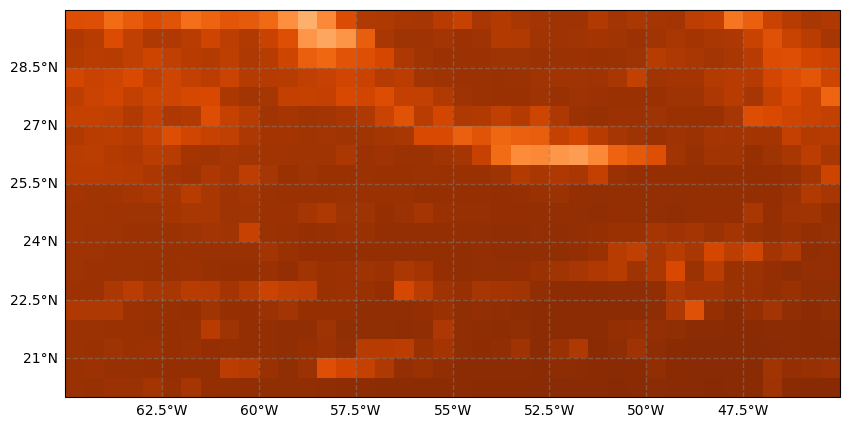

In [26]:
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the map extent to focus on California region
ax.set_extent([-65, -45, 20, 30], crs=ccrs.PlateCarree())

# Plot the GOES data using pcolormesh with the calculated lat/lon
ax.pcolormesh(DownwardShortwaveDataset['lon'][0,:], DownwardShortwaveDataset['lat'][0,:], DownwardShortwaveDataset['DownwardSW'][0,:,:], transform=ccrs.PlateCarree(), cmap='Oranges', shading='auto')

# Add coastlines and map features for context
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle=':')

# Add latitude/longitude gridlines and labels
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False  # Don't show labels on the top
gl.right_labels = False  # Don't show labels on the right
gl.xlabel_style = {'size': 10, 'color': 'black'}
gl.ylabel_style = {'size': 10, 'color': 'black'}

# Show the plot
plt.show()

In [27]:
# Save CloudOpticalDepthDataset as a NetCDF file
DownwardShortwaveDataset.to_netcdf("/glade/work/adhall/Data/GOES_DATA/ProcessGOESData/ProcessedNetCDF/DownwardSWDataset.nc")

In [28]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
from scipy import stats
from scipy.interpolate import griddata

In [29]:
def crop_da(ds,min_lon,max_lon,min_lat,max_lat):

    mask_lon = (ds.lon >= min_lon) & (ds.lon <= max_lon)
    mask_lat = (ds.lat >= min_lat) & (ds.lat <= max_lat)

    ds = ds.where(mask_lon & mask_lat, drop=True)
    return ds

In [30]:
def rgb_to_grayscale(da):
    """Converts an RGB xarray DataArray to grayscale."""
    return (da.sel(rgb='red') * 0.2989 + 
            da.sel(rgb='green') * 0.5870 + 
            da.sel(rgb='blue') * 0.1140)

In [31]:


def remapping_3d_fields(xr_input,vars, output_lons, output_lats,output_times=None):

    input_lons = xr_input['lon'].values
    input_lats = xr_input['lat'].values
    input_times = xr_input['time'].values

    if output_times is None:
        output_times = input_times

    if len(input_lons.shape)==1:
        input_lons3, input_lats3= np.meshgrid(input_lons, input_lats)
    elif len(input_lons.shape)==2:

        input_lons3, input_lats3= np.meshgrid(input_lons[0,:], input_lats[0,:])
        # input_lons3 = np.repeat(input_lons[:,None,:], input_lats.shape[-1],axis=1)
        # input_lats3 = np.repeat(input_lats[:,:,None], input_lons.shape[-1],axis=2)
        # input_times3 = np.repeat(input_times[:,None], input_lons.shape[1],axis=1)
        # input_times3 = np.repeat(input_times3[:,:,None], input_lons.shape[2],axis=2)
    elif len(input_lons.shape)==3:
        input_lons3 = input_lons[0,...]
        input_lats3 = input_lats[0,...]
        # input_times3 = np.repeat(input_times[:,None], input_lons.shape[1],axis=1)
        # input_times3 = np.repeat(input_times3[:,:,None], input_lons.shape[2],axis=2)
    
    if len(output_lons.shape)==1:
        output_lons3, output_lats3 = np.meshgrid(output_lons, output_lats)
    elif len(output_lons.shape)==2:
        output_lons3, output_lats3= np.meshgrid(output_lons[0,:], output_lats[0,:])
        # output_lons3 = np.repeat(output_lons[:,None,:], output_lats.shape[-1],axis=1)
        # output_lats3 = np.repeat(output_lats[:,:,None], output_lons.shape[-1],axis=2)
        # output_times3 = np.repeat(output_times[:,  None], output_lons.shape[1],axis=1)
        # output_times3 = np.repeat(output_times3[:,:,None], output_lons.shape[2],axis=2)
    elif len(output_lons.shape)==3:
        output_lons3 = output_lons[0,...]
        output_lats3 = output_lats[0,...]
        # output_times3 = np.repeat(output_times[:,  None], output_lons.shape[1],axis=1)
        # output_times3 = np.repeat(output_times3[:,:,None], output_lons.shape[2],axis=2)
    
    input_lons3 = input_lons3.flatten()
    input_lats3 = input_lats3.flatten()
    # input_times3 = input_times3.flatten()
    # output_lons3 = output_lons3.flatten()
    # output_lats3 = output_lats3.flatten()
    # output_times3 = output_times3.flatten()

    input_points  = np.vstack((input_lons3 , input_lats3 )).T
    output_points = (output_lons3, output_lats3)
    xr_output = xr.Dataset({})
    # xr_output = xr.Dataset({'time': output_times, 'latitude': output_lats, 'longitude': output_lons})

    
    for var in vars:
        print(var)
        output_field = np.zeros((len(input_times),output_lons3.shape[0],output_lons3.shape[1]))
        for itime in range(len(input_times)):
            print('Time:', output_times[itime])
            input_field = xr_input[var].isel(time=itime).values
            output_field[itime,...] = griddata(input_points, input_field.flatten(), output_points, method='linear')
        xr_output[var] = xr.DataArray(output_field, dims=['time','latitude', 'longitude'], coords={'time': output_times,'latitude': output_lats, 'longitude': output_lons})
    return xr_output
    

In [32]:
direc_data = "/glade/work/adhall/Data/GOES_DATA/ProcessGOESData/ProcessedNetCDF/"

In [33]:
# Define the region of interest

min_lon = -65
max_lon = -45
min_lat = 20
max_lat = 30

In [34]:
ds_dsr = xr.open_dataset(f'{direc_data}DownwardSWDataset.nc')

In [32]:
ds_dsr = crop_da(ds_co,min_lon,max_lon,min_lat,max_lat)

In [33]:
ds_co=ds_co.isel(latitude=slice(None, None, -1))

In [34]:
# Define the new range and resolution
lon_start, lon_end = -65, -45  # Longitude range
lat_start, lat_end = 20, 30    # Latitude range
resolution = 0.25              # Resolution in degrees

# Create remapped grids
lon_remapped = np.arange(lon_start, lon_end + resolution, resolution)
lat_remapped = np.arange(lat_start, lat_end + resolution, resolution)

In [35]:
ds_co_remapped = remapping_3d_fields(ds_co, ['DownwardSW'], lon_remapped, lat_remapped,None)

DownwardSW
Time: 92
Time: 93
Time: 94
Time: 95
Time: 96
Time: 97
Time: 98
Time: 99
Time: 100
Time: 101
Time: 102
Time: 103
Time: 104
Time: 105
Time: 106
Time: 107
Time: 108
Time: 109
Time: 110
Time: 111
Time: 112
Time: 113
Time: 114
Time: 115
Time: 116
Time: 117
Time: 118
Time: 119
Time: 120
Time: 121


In [36]:
# Define metadata dictionary
dataset_metadata_cod = {
    "title": "Downward Shortwave",
    "description": "Combined downward shortwave data over time for Julian days 91 to 100.",
    "source": "GOES-16 Satellite Cloud and Moisture Imagery",
    "history": "Created on 2024-12-02.",
    "institution": "University of Washington",
    "references": "https://registry.opendata.aws/noaa-goes/",
    "time_units": "Julian days",
    "lat_units": "degrees_north",
    "lon_units": "degrees_east",
    "dsr_units": "W/m2"
}

In [37]:
ds_co_remapped.attrs.update(dataset_metadata_cod)
ds_co_remapped.attrs['title'] = "Downward Shortwave Remapped"
ds_co_remapped.to_netcdf('/glade/work/adhall/Data/GOES_DATA/ProcessGOESData/RemappedNetCDF/DownwardSW_remapped.nc')

In [38]:
ds_co_remapped

<xarray.Dataset> Size: 798kB
Dimensions:     (time: 30, latitude: 41, longitude: 81)
Coordinates:
  * time        (time) int64 240B 92 93 94 95 96 97 ... 116 117 118 119 120 121
  * latitude    (latitude) float64 328B 20.0 20.25 20.5 ... 29.5 29.75 30.0
  * longitude   (longitude) float64 648B -65.0 -64.75 -64.5 ... -45.25 -45.0
Data variables:
    DownwardSW  (time, latitude, longitude) float64 797kB nan nan ... nan nan
Attributes:
    title:        Downward Shortwave Remapped
    description:  Combined downward shortwave data over time for Julian days ...
    source:       GOES-16 Satellite Cloud and Moisture Imagery
    history:      Created on 2024-12-02.
    institution:  University of Washington
    references:   https://registry.opendata.aws/noaa-goes/
    time_units:   Julian days
    lat_units:    degrees_north
    lon_units:    degrees_east
    dsr_units:    W/m2

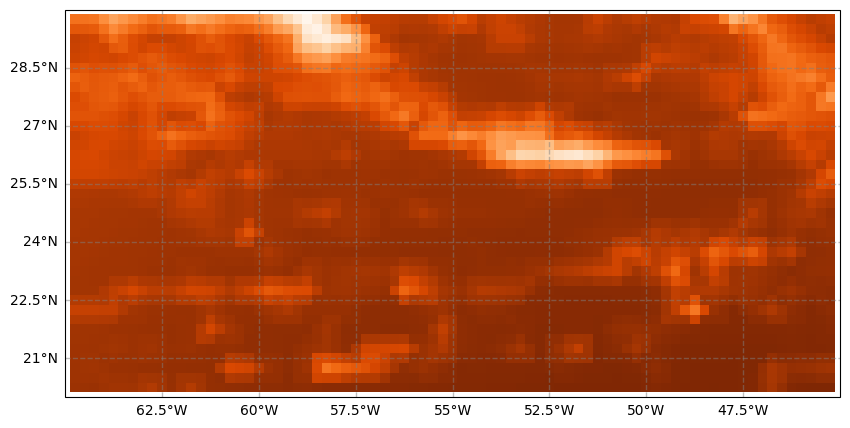

In [40]:
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the map extent to focus on California region
ax.set_extent([-65, -45, 20, 30], crs=ccrs.PlateCarree())

# Plot the GOES data using pcolormesh with the calculated lat/lon
ax.pcolormesh(ds_co_remapped['longitude'][:], ds_co_remapped['latitude'][:], ds_co_remapped['DownwardSW'][0,:,:], transform=ccrs.PlateCarree(), cmap='Oranges', shading='auto')

# Add coastlines and map features for context
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle=':')

# Add latitude/longitude gridlines and labels
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False  # Don't show labels on the top
gl.right_labels = False  # Don't show labels on the right
gl.xlabel_style = {'size': 10, 'color': 'black'}
gl.ylabel_style = {'size': 10, 'color': 'black'}

# Show the plot
plt.show()